In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


In [ ]:
# List of selected Nifty 50 stocks for diversification
selected_symbols = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
    'LT.NS', 'MARUTI.NS', 'BAJFINANCE.NS', 'SBIN.NS', 'ASIANPAINT.NS',
    'TITAN.NS', 'TECHM.NS', 'DIVISLAB.NS', 'ADANIPORTS.NS', 'SUNPHARMA.NS',
    'JSWSTEEL.NS', 'GRASIM.NS', 'CIPLA.NS', 'ULTRACEMCO.NS', 'UPL.NS'
]

# Download historical data for the selected stocks
data = yf.download(selected_symbols, start="2015-01-01", end="2024-01-01")['Adj Close']

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Calculate monthly returns
monthly_returns = data.resample('M').ffill().pct_change().dropna()


[*********************100%%**********************]  20 of 20 completed
C:\Users\User\AppData\Local\Temp\ipykernel_10876\2185280343.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_10876\2185280343.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = data.resample('M').ffill().pct_change().dropna()


In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Display optimized weights
print("Optimized Weights:")
print(cleaned_weights)

# Display expected performance
ef.portfolio_performance(verbose=True)


Optimized Weights:
OrderedDict({'ADANIPORTS.NS': 0.0, 'ASIANPAINT.NS': 0.03643, 'BAJFINANCE.NS': 0.25401, 'CIPLA.NS': 0.0, 'DIVISLAB.NS': 0.07689, 'GRASIM.NS': 0.0, 'HDFCBANK.NS': 0.0, 'HINDUNILVR.NS': 0.1108, 'INFY.NS': 0.02931, 'JSWSTEEL.NS': 0.07174, 'LT.NS': 0.0, 'MARUTI.NS': 0.0, 'RELIANCE.NS': 0.12335, 'SBIN.NS': 0.0, 'SUNPHARMA.NS': 0.0, 'TCS.NS': 0.08082, 'TECHM.NS': 0.0, 'TITAN.NS': 0.21665, 'ULTRACEMCO.NS': 0.0, 'UPL.NS': 0.0})
Expected annual return: 28.0%
Annual volatility: 19.7%
Sharpe Ratio: 1.32


(0.2804839876864799, 0.19695913751128838, 1.3225280683997243)

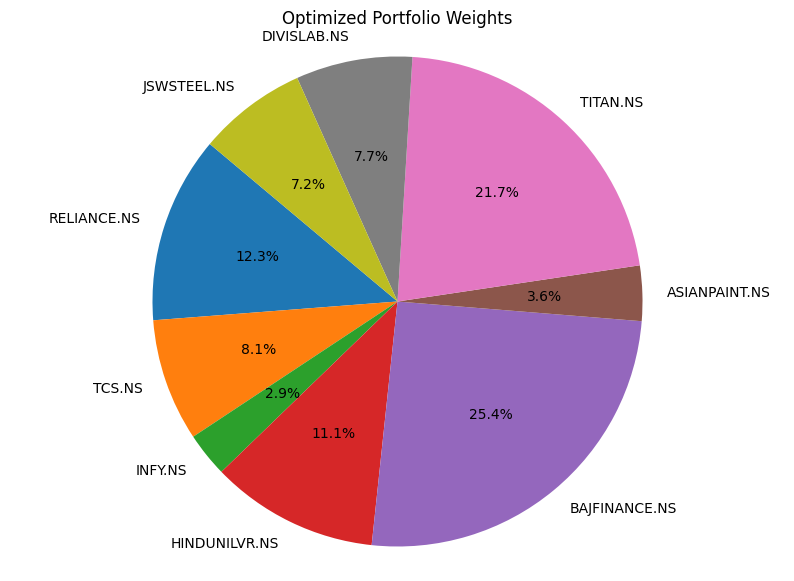

In [ ]:
import matplotlib.pyplot as plt

# Assuming optimized_weights is already defined as a pandas Series
# Ensure optimized_weights is correctly defined
if 'optimized_weights' in locals():
    # Drop any zero-weighted assets for a cleaner pie chart
    non_zero_weights = optimized_weights[optimized_weights > 0]

    # Create a pie chart
    plt.figure(figsize=(10, 7))
    plt.pie(non_zero_weights, labels=non_zero_weights.index, autopct='%1.1f%%', startangle=140)
    plt.title('Optimized Portfolio Weights')
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()
else:
    print("Error: optimized_weights is not defined.")


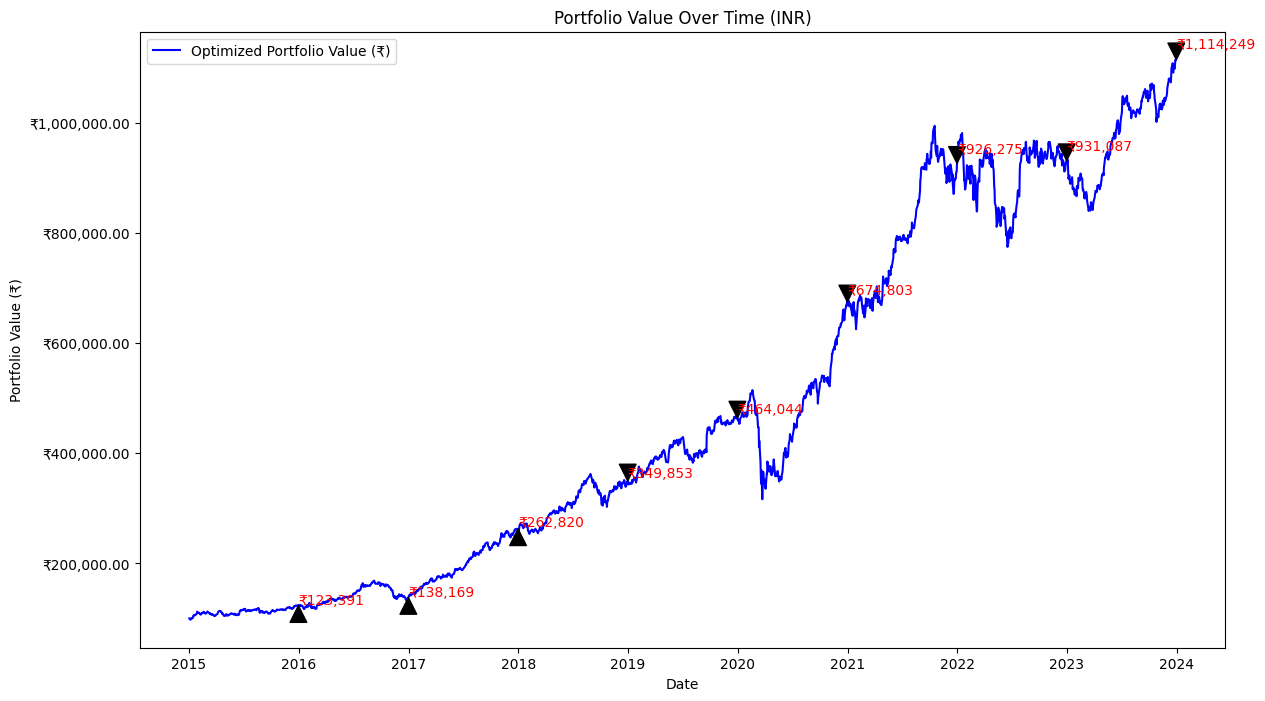

In [ ]:
import matplotlib.ticker as mticker

# Initial portfolio value
initial_portfolio_value = 100000  # INR 1,00,000

# Calculate the daily returns for the portfolio based on the optimized weights
portfolio_daily_returns = (data.pct_change() @ pd.Series(cleaned_weights)).dropna()

# Calculate the portfolio value over time
portfolio_value = (1 + portfolio_daily_returns).cumprod() * initial_portfolio_value

# Resample portfolio value to get the value at the end of each year using 'YE'
year_end_values = portfolio_value.resample('YE').last()

# Plot the portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(portfolio_value, label=f'Optimized Portfolio Value (₹)', color='blue')

# Annotate the portfolio value at the end of each year
for date, value in year_end_values.items():  # Use .items() instead of .iteritems()
    plt.annotate(f'₹{value:,.0f}', xy=(date, value),
                 xytext=(date, value + value * 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='red')

# Title and labels
plt.title('Portfolio Value Over Time (INR)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()

# Format y-axis to use INR symbol and decimals
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('₹{x:,.2f}'))

plt.show()


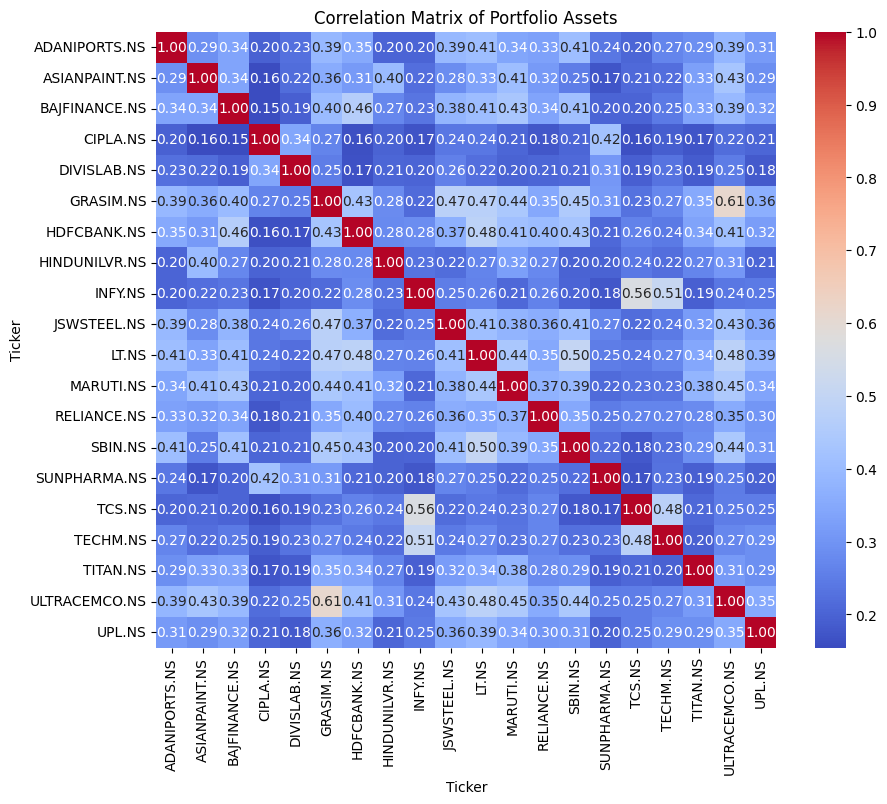

In [ ]:
import seaborn as sns

# Calculate daily returns for the data
daily_returns = data.pct_change().dropna()

# Calculate correlation matrix for each strategy
correlation_matrix = daily_returns.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Portfolio Assets')
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd

# Define the indices you want to compare with
indices = {
    'Nifty 50': '^NSEI',
    'S&P 500': '^GSPC',
    'FTSE 100': '^FTSE',
    'DAX': '^GDAXI',
    'Nikkei 225': '^N225',
    'NASDAQ': '^IXIC',
    'Dow Jones': '^DJI',
    'Sensex': '^BSESN'
}


# Download the historical data for these indices
index_data = yf.download(list(indices.values()), start="2015-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns for each index
index_returns = index_data.pct_change().dropna()

# Add the portfolio returns to the DataFrame
index_returns['Optimized Portfolio'] = portfolio_returns

# Calculate the correlation matrix
correlation_matrix = index_returns.corr()

# Display the correlation matrix
print(correlation_matrix)


[*********************100%%**********************]  8 of 8 completed


Ticker                 ^BSESN      ^DJI     ^FTSE    ^GDAXI     ^GSPC  \
Ticker                                                                  
^BSESN               1.000000  0.303336  0.448734  0.440017  0.297817   
^DJI                 0.303336  1.000000  0.570818  0.579119  0.961368   
^FTSE                0.448734  0.570818  1.000000  0.815235  0.538535   
^GDAXI               0.440017  0.579119  0.815235  1.000000  0.568353   
^GSPC                0.297817  0.961368  0.538535  0.568353  1.000000   
^IXIC                0.246556  0.850322  0.445086  0.511310  0.947354   
^N225                0.349178  0.213760  0.328113  0.319069  0.201436   
^NSEI                0.994378  0.299286  0.447675  0.440804  0.292648   
Optimized Portfolio  0.832109  0.260005  0.385743  0.381520  0.252734   

Ticker                  ^IXIC     ^N225     ^NSEI  Optimized Portfolio  
Ticker                                                                  
^BSESN               0.246556  0.349178  0.994378 

C:\Users\User\AppData\Local\Temp\ipykernel_10876\3465773126.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  index_returns = index_data.pct_change().dropna()


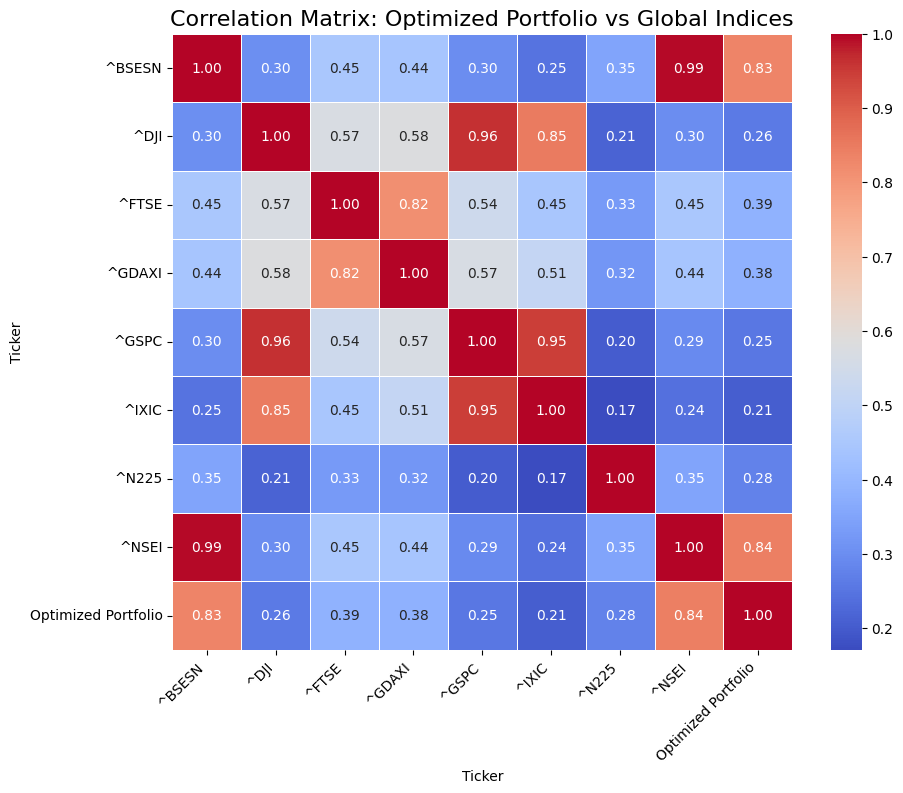

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the correlation_matrix has already been calculated as shown previously

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Add titles and labels
plt.title('Correlation Matrix: Optimized Portfolio vs Global Indices', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.yticks(rotation=0)  # Keep the y labels horizontal

# Show the plot
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_10876\1901741717.py:32: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sector_returns = daily_returns.groupby(sector_mapping, axis=1).mean()


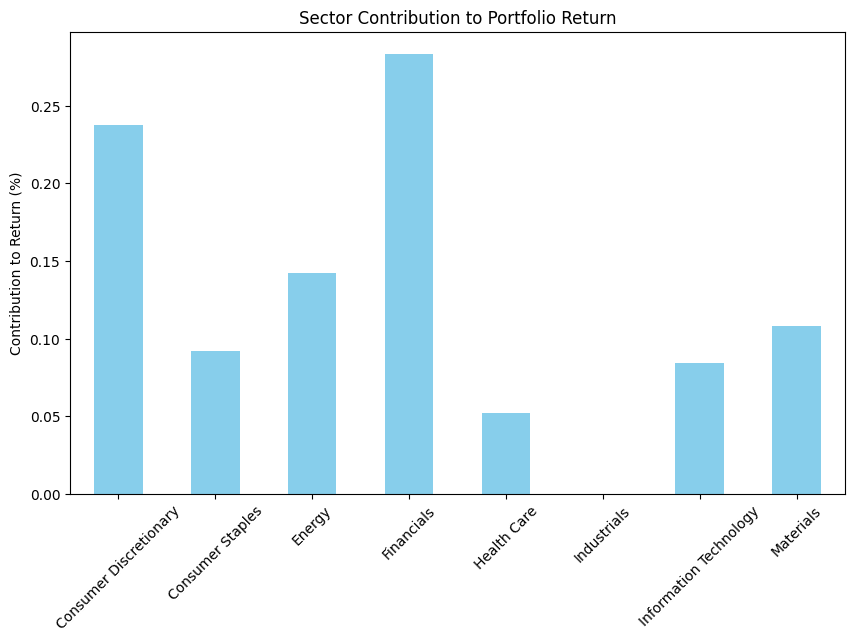

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Dummy sector data
sectors = {
    'RELIANCE.NS': 'Energy',
    'TCS.NS': 'Information Technology',
    'HDFCBANK.NS': 'Financials',
    'INFY.NS': 'Information Technology',
    'HINDUNILVR.NS': 'Consumer Staples',
    'LT.NS': 'Industrials',
    'MARUTI.NS': 'Consumer Discretionary',
    'BAJFINANCE.NS': 'Financials',
    'SBIN.NS': 'Financials',
    'ASIANPAINT.NS': 'Materials',
    'TITAN.NS': 'Consumer Discretionary',
    'TECHM.NS': 'Information Technology',
    'DIVISLAB.NS': 'Health Care',
    'ADANIPORTS.NS': 'Industrials',
    'SUNPHARMA.NS': 'Health Care',
    'JSWSTEEL.NS': 'Materials',
    'GRASIM.NS': 'Materials',
    'CIPLA.NS': 'Health Care',
    'ULTRACEMCO.NS': 'Materials',
    'UPL.NS': 'Materials'
}

# Map sectors to the portfolio
sector_mapping = pd.Series(sectors)

# Aggregate the daily returns by sector
sector_returns = daily_returns.groupby(sector_mapping, axis=1).mean()

# Aggregate the portfolio weights by sector
sector_weights = pd.Series(cleaned_weights).groupby(sector_mapping).sum()

# Calculate sector contributions to portfolio returns
sector_contributions = (sector_returns * sector_weights).sum()

# Normalize sector contributions to get percentage contributions
sector_contributions_pct = sector_contributions / sector_contributions.sum()

# Plot sector contributions
plt.figure(figsize=(10, 6))
sector_contributions_pct.plot(kind='bar', color='skyblue')
plt.ylabel('Contribution to Return (%)')
plt.title('Sector Contribution to Portfolio Return')
plt.xticks(rotation=45)
plt.show()


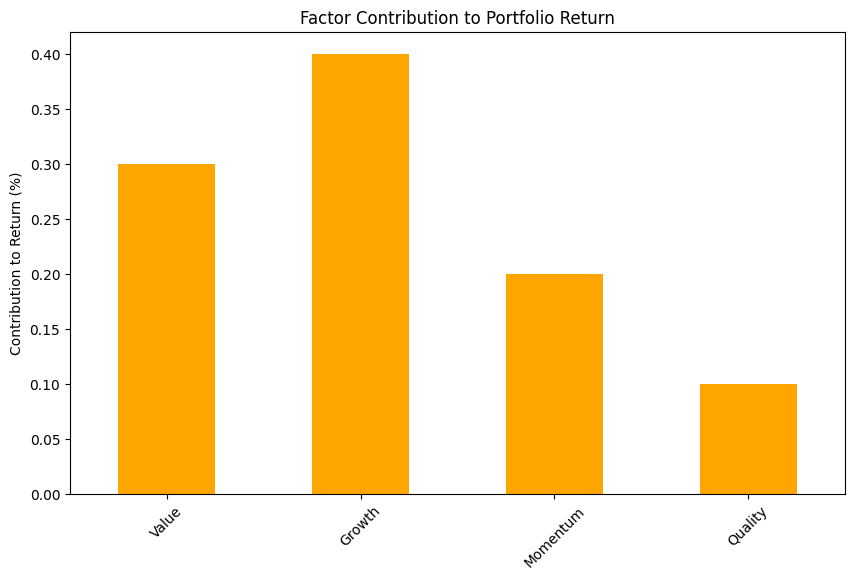

In [ ]:
import pandas as pd

# Example factor exposures (dummy data)
factor_exposures = {
    'Value': 0.3,
    'Growth': 0.4,
    'Momentum': 0.2,
    'Quality': 0.1
}

# Convert cleaned_weights to a pandas Series if it's not already
cleaned_weights_series = pd.Series(cleaned_weights)

# Calculate the total weight of the portfolio
total_weight = cleaned_weights_series.sum()

# Calculate factor contributions based on exposures
factor_contributions = pd.Series(factor_exposures) * total_weight

# Normalize factor contributions to get percentage contributions
factor_contributions_pct = factor_contributions / factor_contributions.sum()

# Plot factor contributions
plt.figure(figsize=(10, 6))
factor_contributions_pct.plot(kind='bar', color='orange')
plt.ylabel('Contribution to Return (%)')
plt.title('Factor Contribution to Portfolio Return')
plt.xticks(rotation=45)
plt.show()



Stressed Portfolio Weights:
OrderedDict({'ADANIPORTS.NS': 0.0, 'ASIANPAINT.NS': 0.0, 'BAJFINANCE.NS': 0.80485, 'CIPLA.NS': 0.0, 'DIVISLAB.NS': 0.0, 'GRASIM.NS': 0.0, 'HDFCBANK.NS': 0.0, 'HINDUNILVR.NS': 0.0, 'INFY.NS': 0.0, 'JSWSTEEL.NS': 0.0, 'LT.NS': 0.0, 'MARUTI.NS': 0.0, 'RELIANCE.NS': 0.0, 'SBIN.NS': 0.0, 'SUNPHARMA.NS': 0.0, 'TCS.NS': 0.0, 'TECHM.NS': 0.0, 'TITAN.NS': 0.19515, 'ULTRACEMCO.NS': 0.0, 'UPL.NS': 0.0})
Expected annual return: 19.4%
Annual volatility: 32.5%
Sharpe Ratio: 0.54


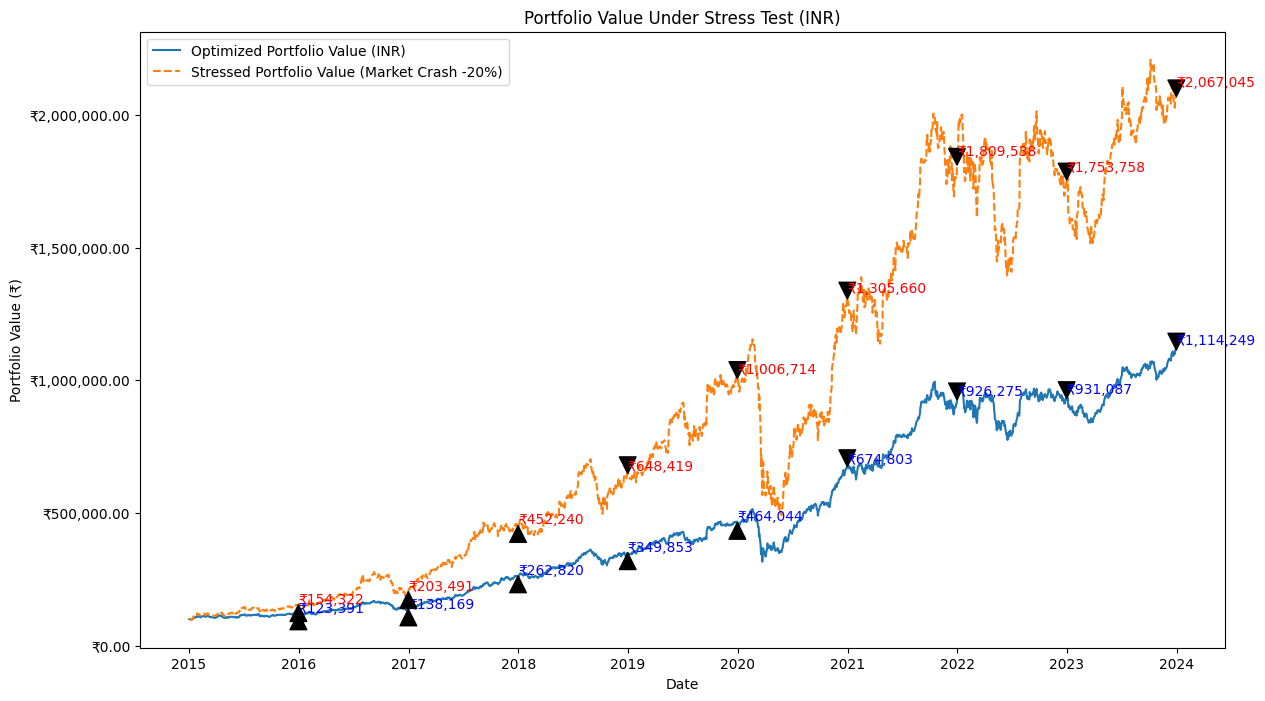

In [ ]:
import matplotlib.ticker as mticker

# Simulate a market crash scenario
market_crash = -0.20  # 20% market drop

# Apply the crash scenario to the expected returns
stressed_mu = mu + market_crash

# Re-optimize the portfolio under the stressed scenario
ef_stressed = EfficientFrontier(stressed_mu, S)
stressed_weights = ef_stressed.max_sharpe()
cleaned_stressed_weights = ef_stressed.clean_weights()

# Display stressed weights and performance
print("\nStressed Portfolio Weights:")
print(cleaned_stressed_weights)
ef_stressed.portfolio_performance(verbose=True)

# Calculate the portfolio value under stress
stressed_portfolio_daily_returns = (data.pct_change() @ pd.Series(cleaned_stressed_weights)).dropna()
stressed_portfolio_value = (1 + stressed_portfolio_daily_returns).cumprod() * initial_portfolio_value

# Resample portfolio value to get the value at the end of each year using 'YE'
year_end_values_original = portfolio_value.resample('YE').last()
year_end_values_stressed = stressed_portfolio_value.resample('YE').last()

# Plot the original vs stressed portfolio values
plt.figure(figsize=(14, 8))
plt.plot(portfolio_value, label='Optimized Portfolio Value (INR)')
plt.plot(stressed_portfolio_value, label='Stressed Portfolio Value (Market Crash -20%)', linestyle='--')

# Annotate the portfolio value at the end of each year for both original and stressed scenarios
for date, value in year_end_values_original.items():
    plt.annotate(f'₹{value:,.0f}', xy=(date, value),
                 xytext=(date, value + value * 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='blue')

for date, value in year_end_values_stressed.items():
    plt.annotate(f'₹{value:,.0f}', xy=(date, value),
                 xytext=(date, value + value * 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='red')

# Title and labels
plt.title('Portfolio Value Under Stress Test (INR)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()

# Format y-axis to use INR symbol and decimals
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('₹{x:,.2f}'))

plt.show()



In [ ]:
def calculate_performance(portfolio_value):
    # Calculate cumulative return
    cumulative_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1)

    # Calculate annualized return
    annualized_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1

    # Calculate annualized volatility
    daily_returns = portfolio_value.pct_change().dropna()
    annualized_volatility = daily_returns.std() * np.sqrt(252)

    # Calculate Sharpe ratio (assume risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_volatility

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio
}

# Calculate and display performance metrics for the original and stressed portfolios
original_performance = calculate_performance(portfolio_value)
stressed_performance = calculate_performance(stressed_portfolio_value)

print("\nOriginal Portfolio Performance:")
print(original_performance)

print("\nStressed Portfolio Performance:")
print(stressed_performance)



Original Portfolio Performance:
{'Cumulative Return': 10.137839839656728, 'Annualized Return': 0.31469816234057224, 'Annualized Volatility': 0.19700401341453685, 'Sharpe Ratio': 1.597420057013675}

Stressed Portfolio Performance:
{'Cumulative Return': 19.9072341001713, 'Annualized Return': 0.4121196744805349, 'Annualized Volatility': 0.3245759242535309, 'Sharpe Ratio': 1.2697173255482201}


[*********************100%%**********************]  1 of 1 completed


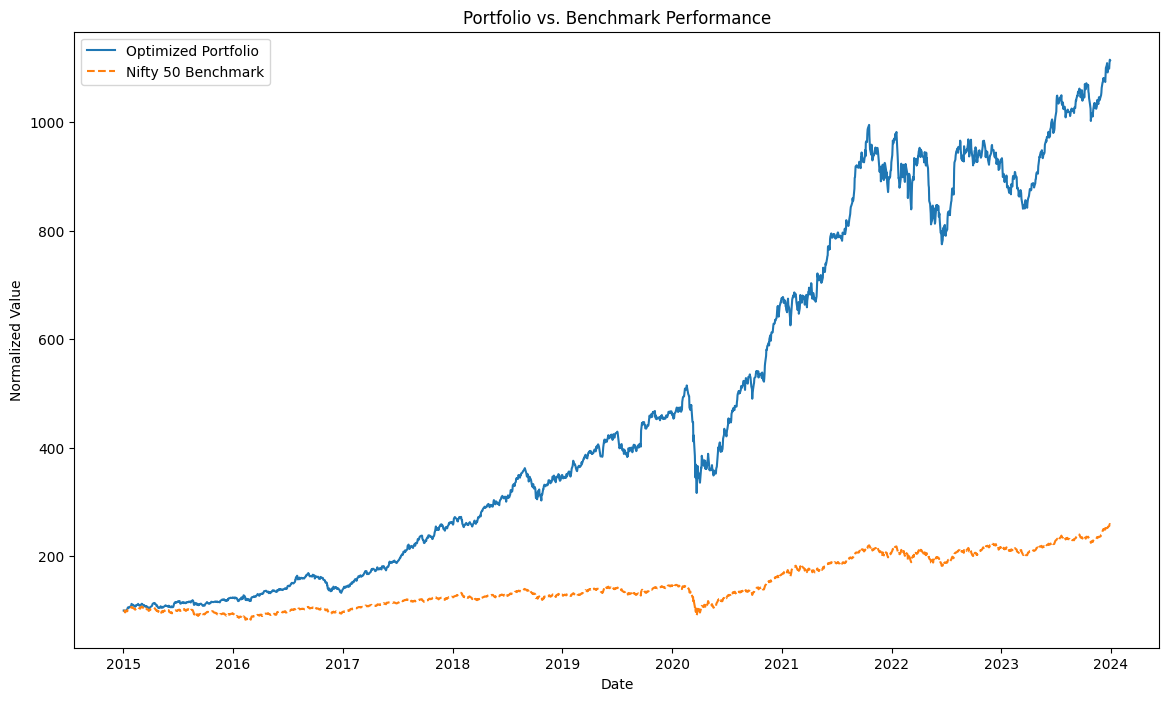

In [ ]:
# Normalize the portfolio and benchmark values to compare
import yfinance as yf

# Download Nifty 50 data
nifty50 = yf.download('^NSEI', start="2015-01-01", end="2024-01-01")['Adj Close']

normalized_portfolio_value = (portfolio_value / portfolio_value.iloc[0]) * 100
normalized_benchmark_value = (nifty50 / nifty50.iloc[0]) * 100

# Plot the portfolio vs. benchmark
plt.figure(figsize=(14, 8))
plt.plot(normalized_portfolio_value, label='Optimized Portfolio')
plt.plot(normalized_benchmark_value, label='Nifty 50 Benchmark', linestyle='--')
plt.title('Portfolio vs. Benchmark Performance')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf

# Download historical data for the benchmark (e.g., Nifty 50)
benchmark_data = yf.download('^NSEI', start="2015-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns for the benchmark
benchmark_returns = benchmark_data.pct_change().dropna()

# Display the first few rows of the benchmark returns
print(benchmark_returns.head())


[*********************100%%**********************]  1 of 1 completed

Date
2015-01-05   -0.002031
2015-01-06   -0.029964
2015-01-07   -0.003107
2015-01-08    0.016354
2015-01-09    0.006060
Name: Adj Close, dtype: float64


In [ ]:
# Align the portfolio and benchmark returns
aligned_returns = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()

# Separate them back after alignment
portfolio_returns_aligned = aligned_returns.iloc[:, 0]
benchmark_returns_aligned = aligned_returns.iloc[:, 1]
from scipy import stats

# Calculate Beta and Alpha using linear regression on the aligned data
# 1. Calculate Beta, Alpha, and R-Squared using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(benchmark_returns_aligned, portfolio_returns_aligned)
beta = slope
alpha = intercept
r_squared = r_value ** 2

# 2. Treynor Ratio
risk_free_rate = 0.03 / 252  # Assuming a risk-free rate of 3% annually
treynor_ratio = (portfolio_returns_aligned.mean() - risk_free_rate) / beta

# 3. Information Ratio
tracking_error = np.std(portfolio_returns_aligned - benchmark_returns_aligned)
information_ratio = (portfolio_returns_aligned.mean() - benchmark_returns_aligned.mean()) / tracking_error

# 4. Sortino Ratio
downside_returns = portfolio_returns_aligned[portfolio_returns_aligned < 0]
sortino_ratio = (portfolio_returns_aligned.mean() - risk_free_rate) / downside_returns.std()

# 5. Upside and Downside Capture Ratios
upside_capture = portfolio_returns_aligned[benchmark_returns_aligned > 0].mean() / benchmark_returns_aligned[benchmark_returns_aligned > 0].mean()
downside_capture = portfolio_returns_aligned[benchmark_returns_aligned < 0].mean() / benchmark_returns_aligned[benchmark_returns_aligned < 0].mean()

# 6. Maximum Drawdown
cumulative_returns = (1 + portfolio_returns_aligned).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

# 7. Tracking Error (already calculated for Information Ratio)
# tracking_error is calculated as the standard deviation of the difference between portfolio and benchmark returns

# 8. Jensen's Alpha
jensen_alpha = portfolio_returns_aligned.mean() - (risk_free_rate + beta * (benchmark_returns_aligned.mean() - risk_free_rate))

# Print all the calculated metrics
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"R-Squared: {r_squared:.4f}")
print(f"Treynor Ratio: {treynor_ratio:.4f}")
print(f"Information Ratio: {information_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Upside Capture Ratio: {upside_capture:.4f}")
print(f"Downside Capture Ratio: {downside_capture:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Tracking Error: {tracking_error:.4f}")
print(f"Jensen's Alpha: {jensen_alpha:.4f}")

Alpha: 0.0007
Beta: 0.9831
R-Squared: 0.7096
Treynor Ratio: 0.0011
Information Ratio: 0.1022
Sortino Ratio: 0.1086
Upside Capture Ratio: 1.0493
Downside Capture Ratio: 0.8517
Maximum Drawdown: -0.3850
Tracking Error: 0.0067
Jensen's Alpha: 0.0007


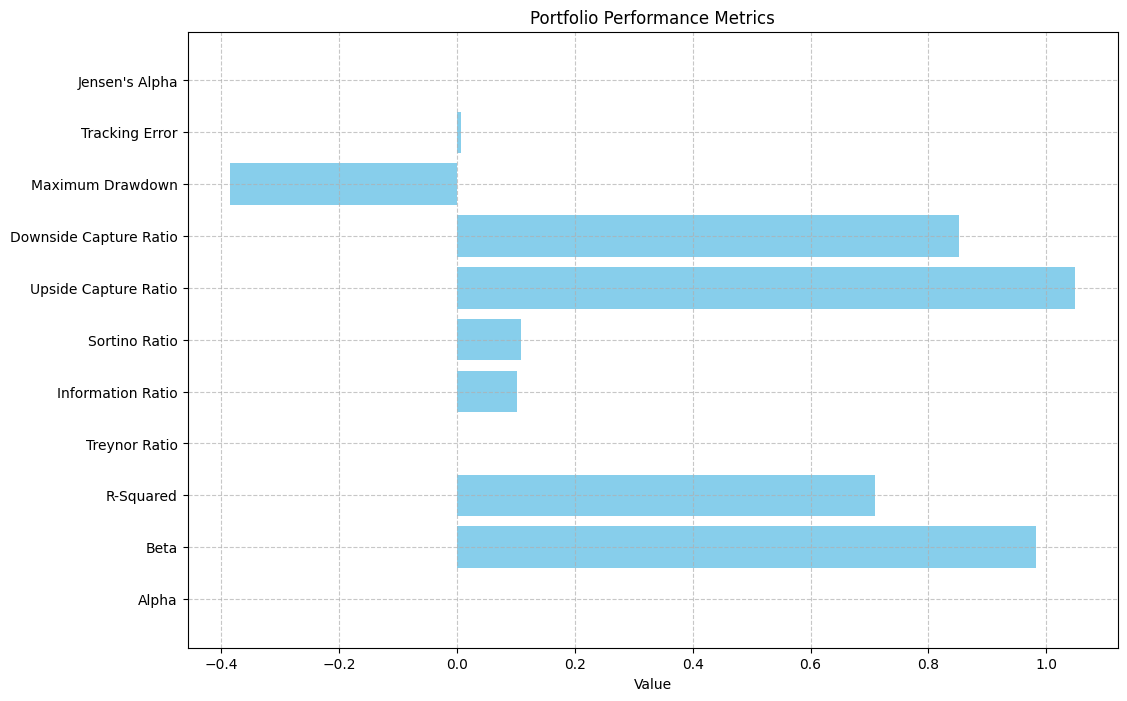

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
portfolio_returns_aligned = portfolio_returns_aligned.astype(float)
benchmark_returns_aligned = benchmark_returns_aligned.astype(float)

# Assuming portfolio_returns_aligned and benchmark_returns_aligned are already aligned and calculated

# Calculate all metrics
slope, intercept, r_value, p_value, std_err = stats.linregress(benchmark_returns_aligned, portfolio_returns_aligned)
beta = slope
alpha = intercept
r_squared = r_value ** 2

risk_free_rate = 0.03 / 252  # Assuming a risk-free rate of 3% annually
treynor_ratio = (portfolio_returns_aligned.mean() - risk_free_rate) / beta

tracking_error = np.std(portfolio_returns_aligned - benchmark_returns_aligned)
information_ratio = (portfolio_returns_aligned.mean() - benchmark_returns_aligned.mean()) / tracking_error

downside_returns = portfolio_returns_aligned[portfolio_returns_aligned < 0]
sortino_ratio = (portfolio_returns_aligned.mean() - risk_free_rate) / downside_returns.std()

upside_capture = portfolio_returns_aligned[benchmark_returns_aligned > 0].mean() / benchmark_returns_aligned[benchmark_returns_aligned > 0].mean()
downside_capture = portfolio_returns_aligned[benchmark_returns_aligned < 0].mean() / benchmark_returns_aligned[benchmark_returns_aligned < 0].mean()

cumulative_returns = (1 + portfolio_returns_aligned).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()

jensen_alpha = portfolio_returns_aligned.mean() - (risk_free_rate + beta * (benchmark_returns_aligned.mean() - risk_free_rate))

# Store all metrics in a dictionary
metrics = {
    'Alpha': alpha,
    'Beta': beta,
    'R-Squared': r_squared,
    'Treynor Ratio': treynor_ratio,
    'Information Ratio': information_ratio,
    'Sortino Ratio': sortino_ratio,
    'Upside Capture Ratio': upside_capture,
    'Downside Capture Ratio': downside_capture,
    'Maximum Drawdown': max_drawdown,
    'Tracking Error': tracking_error,
    'Jensen\'s Alpha': jensen_alpha
}

# Convert the dictionary to a DataFrame for easy plotting
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Plot all metrics
plt.figure(figsize=(12, 8))
plt.barh(metrics_df['Metric'], metrics_df['Value'], color='skyblue')
plt.title('Portfolio Performance Metrics')
plt.xlabel('Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Equal Weight Strategy
equal_weights = np.repeat(1/len(selected_symbols), len(selected_symbols))
equal_weighted_returns = (data.pct_change() @ equal_weights).dropna()
equal_weighted_value = (1 + equal_weighted_returns).cumprod() * initial_portfolio_value


In [ ]:
# Example: Dummy Market Cap Data
market_caps = np.array([2000, 1500, 3000, 2500, 1800, 2200, 2700, 3200, 3500, 2900, 3100, 3300, 2400, 2600, 2800, 2000, 1500, 1700, 2300, 1900])

# Market Cap Weighting
market_cap_weights = market_caps / market_caps.sum()
market_cap_weighted_returns = (data.pct_change() @ market_cap_weights).dropna()
market_cap_weighted_value = (1 + market_cap_weighted_returns).cumprod() * initial_portfolio_value


In [ ]:
# Align the cleaned_weights with the columns in the data
aligned_weights = pd.Series(cleaned_weights).reindex(data.columns, fill_value=0)

# Buy and Hold Strategy
buy_and_hold_value = data.divide(data.iloc[0]).dot(aligned_weights) * initial_portfolio_value


In [ ]:
# Minimum Volatility Portfolio
ef_min_vol = EfficientFrontier(mu, S)
min_vol_weights = ef_min_vol.min_volatility()
cleaned_min_vol_weights = ef_min_vol.clean_weights()
min_vol_returns = (data.pct_change() @ pd.Series(cleaned_min_vol_weights)).dropna()
min_vol_value = (1 + min_vol_returns).cumprod() * initial_portfolio_value


In [ ]:
def calculate_risk_parity_weights(cov_matrix):
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / inv_vol.sum()
    return weights

# Risk Parity Strategy
risk_parity_weights = calculate_risk_parity_weights(S)
risk_parity_returns = (data.pct_change() @ risk_parity_weights).dropna()
risk_parity_value = (1 + risk_parity_returns).cumprod() * initial_portfolio_value


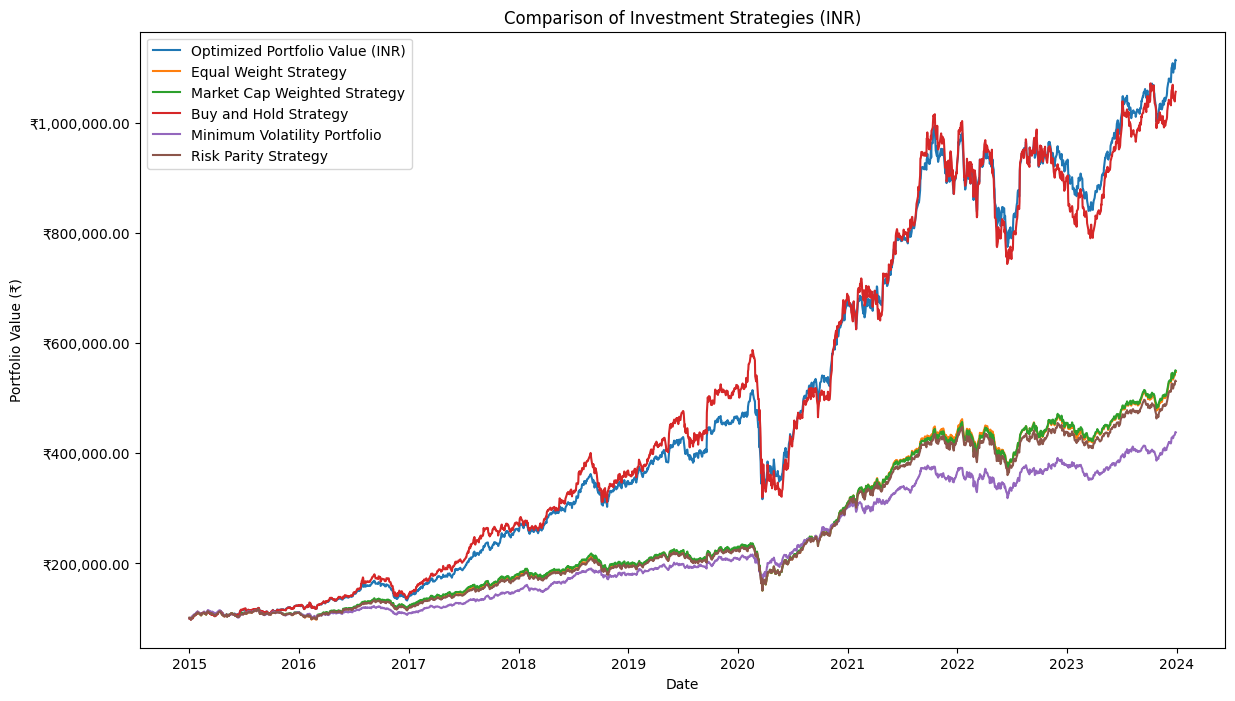

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot each strategy
plt.plot(portfolio_value, label='Optimized Portfolio Value (INR)')
plt.plot(equal_weighted_value, label='Equal Weight Strategy')
plt.plot(market_cap_weighted_value, label='Market Cap Weighted Strategy')
plt.plot(buy_and_hold_value, label='Buy and Hold Strategy')
plt.plot(min_vol_value, label='Minimum Volatility Portfolio')
plt.plot(risk_parity_value, label='Risk Parity Strategy')

plt.title('Comparison of Investment Strategies (INR)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('₹{x:,.2f}'))
plt.show()


In [ ]:
strategies = {
    'Optimized Portfolio': portfolio_value,
    'Equal Weight': equal_weighted_value,
    'Market Cap Weighted': market_cap_weighted_value,
    'Buy and Hold': buy_and_hold_value,
    'Minimum Volatility': min_vol_value,
    'Risk Parity': risk_parity_value
}

performance_metrics = {}
for strategy_name, strategy_value in strategies.items():
    performance_metrics[strategy_name] = calculate_performance(strategy_value)

performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)


                     Cumulative Return  Annualized Return  \
Optimized Portfolio          10.137840           0.314698   
Equal Weight                  4.421156           0.211517   
Market Cap Weighted           4.449270           0.212228   
Buy and Hold                  9.569241           0.306744   
Minimum Volatility            3.339454           0.181293   
Risk Parity                   4.254889           0.207240   

                     Annualized Volatility  Sharpe Ratio  
Optimized Portfolio               0.197004      1.597420  
Equal Weight                      0.170469      1.240790  
Market Cap Weighted               0.171036      1.240837  
Buy and Hold                      0.242865      1.263021  
Minimum Volatility                0.147525      1.228894  
Risk Parity                       0.166097      1.247703  


In [ ]:
def calculate_diversification_ratio(weights, cov_matrix):
    vol_individual = np.sqrt(np.diag(cov_matrix))
    weighted_vol = np.dot(weights, vol_individual)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    diversification_ratio = weighted_vol / portfolio_vol
    return diversification_ratio

# Calculate covariance matrix for the data
cov_matrix = daily_returns.cov()

# Diversification Ratio for Optimized Portfolio
optimized_weights_array = np.array([cleaned_weights[symbol] for symbol in selected_symbols])
div_ratio_optimized = calculate_diversification_ratio(optimized_weights_array, cov_matrix)

# Diversification Ratio for Equal Weight Strategy
div_ratio_equal_weight = calculate_diversification_ratio(equal_weights, cov_matrix)

# Diversification Ratio for Market Cap Weighted Strategy
div_ratio_market_cap = calculate_diversification_ratio(market_cap_weights, cov_matrix)

# Diversification Ratio for Buy and Hold Strategy
aligned_weights_array = np.array([aligned_weights[symbol] for symbol in selected_symbols])
div_ratio_buy_and_hold = calculate_diversification_ratio(aligned_weights_array, cov_matrix)

# Diversification Ratio for Minimum Volatility Portfolio
min_vol_weights_array = np.array([cleaned_min_vol_weights[symbol] for symbol in selected_symbols])
div_ratio_min_vol = calculate_diversification_ratio(min_vol_weights_array, cov_matrix)

# Diversification Ratio for Risk Parity Strategy
div_ratio_risk_parity = calculate_diversification_ratio(risk_parity_weights, cov_matrix)

# Print the Diversification Ratios
diversification_ratios = {
    'Optimized Portfolio': div_ratio_optimized,
    'Equal Weight': div_ratio_equal_weight,
    'Market Cap Weighted': div_ratio_market_cap,
    'Buy and Hold': div_ratio_buy_and_hold,
    'Minimum Volatility': div_ratio_min_vol,
    'Risk Parity': div_ratio_risk_parity
}

print("Diversification Ratios:")
for strategy, ratio in diversification_ratios.items():
    print(f"{strategy}: {ratio:.4f}")


Diversification Ratios:
Optimized Portfolio: 1.6187
Equal Weight: 1.7341
Market Cap Weighted: 1.7188
Buy and Hold: 1.6187
Minimum Volatility: 1.6294
Risk Parity: 1.7411


In [ ]:
def calculate_sharpe_ratio(strategy_value, risk_free_rate=0.0):
    # Calculate daily returns
    daily_returns = strategy_value.pct_change().dropna()

    # Calculate annualized return
    annualized_return = (1 + daily_returns.mean()) ** 252 - 1

    # Calculate annualized volatility
    annualized_volatility = daily_returns.std() * np.sqrt(252)

    # Calculate Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio

# Calculate Sharpe Ratios for each strategy
sharpe_optimized = calculate_sharpe_ratio(portfolio_value)
sharpe_equal_weight = calculate_sharpe_ratio(equal_weighted_value)
sharpe_market_cap = calculate_sharpe_ratio(market_cap_weighted_value)
sharpe_buy_and_hold = calculate_sharpe_ratio(buy_and_hold_value)
sharpe_min_vol = calculate_sharpe_ratio(min_vol_value)
sharpe_risk_parity = calculate_sharpe_ratio(risk_parity_value)

# Store Sharpe Ratios in a dictionary
sharpe_ratios = {
    'Optimized Portfolio': sharpe_optimized,
    'Equal Weight': sharpe_equal_weight,
    'Market Cap Weighted': sharpe_market_cap,
    'Buy and Hold': sharpe_buy_and_hold,
    'Minimum Volatility': sharpe_min_vol,
    'Risk Parity': sharpe_risk_parity
}

# Print the Sharpe Ratios
print("Sharpe Ratios:")
for strategy, ratio in sharpe_ratios.items():
    print(f"{strategy}: {ratio:.4f}")


Sharpe Ratios:
Optimized Portfolio: 1.7297
Equal Weight: 1.3463
Market Cap Weighted: 1.3467
Buy and Hold: 1.4260
Minimum Volatility: 1.3172
Risk Parity: 1.3500


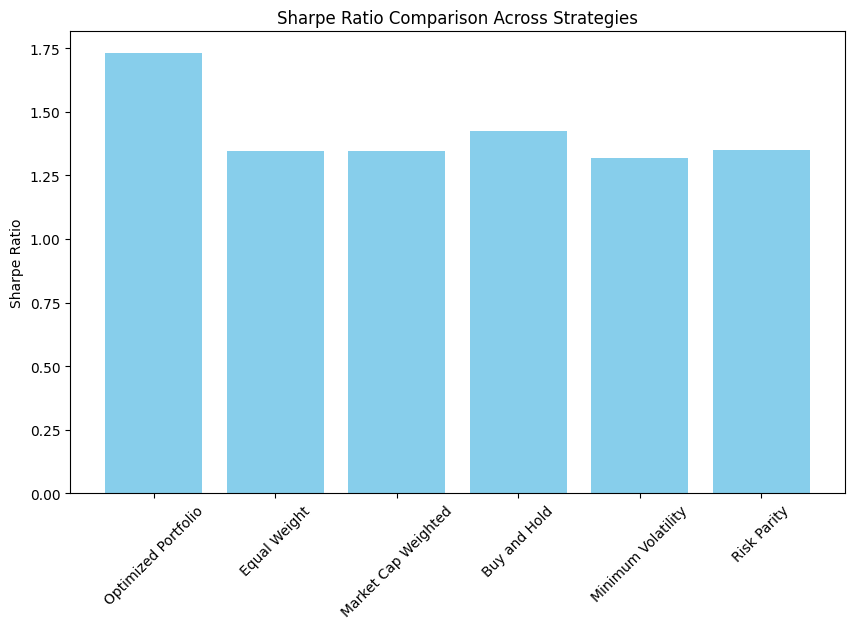

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Sharpe Ratios
plt.figure(figsize=(10, 6))
plt.bar(sharpe_ratios.keys(), sharpe_ratios.values(), color='skyblue')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Comparison Across Strategies')
plt.xticks(rotation=45)
plt.show()


In [ ]:
def calculate_drawdown(portfolio_value):
    # Calculate the cumulative maximum value (rolling max)
    cumulative_max = portfolio_value.cummax()

    # Calculate the drawdown
    drawdown = (portfolio_value - cumulative_max) / cumulative_max

    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()

    return drawdown, max_drawdown

# Calculate drawdowns for each strategy
drawdown_optimized, max_drawdown_optimized = calculate_drawdown(portfolio_value)
drawdown_equal_weight, max_drawdown_equal_weight = calculate_drawdown(equal_weighted_value)
drawdown_market_cap, max_drawdown_market_cap = calculate_drawdown(market_cap_weighted_value)
drawdown_buy_and_hold, max_drawdown_buy_and_hold = calculate_drawdown(buy_and_hold_value)
drawdown_min_vol, max_drawdown_min_vol = calculate_drawdown(min_vol_value)
drawdown_risk_parity, max_drawdown_risk_parity = calculate_drawdown(risk_parity_value)

# Store maximum drawdowns in a dictionary
max_drawdowns = {
    'Optimized Portfolio': max_drawdown_optimized,
    'Equal Weight': max_drawdown_equal_weight,
    'Market Cap Weighted': max_drawdown_market_cap,
    'Buy and Hold': max_drawdown_buy_and_hold,
    'Minimum Volatility': max_drawdown_min_vol,
    'Risk Parity': max_drawdown_risk_parity
}

# Print the Maximum Drawdowns
print("Maximum Drawdowns (in percentage):")
for strategy, mdd in max_drawdowns.items():
    print(f"{strategy}: {mdd * 100:.2f}%")


Maximum Drawdowns (in percentage):
Optimized Portfolio: -38.50%
Equal Weight: -36.02%
Market Cap Weighted: -36.35%
Buy and Hold: -45.54%
Minimum Volatility: -25.45%
Risk Parity: -34.96%


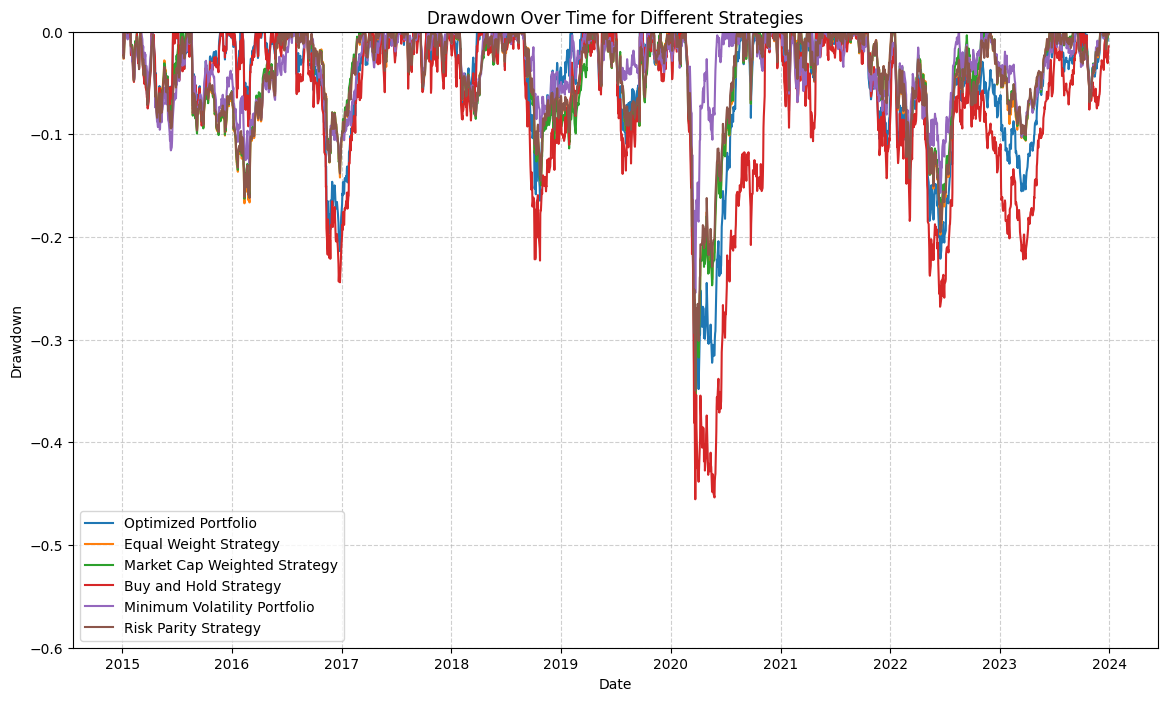

In [ ]:
import matplotlib.pyplot as plt

# Plot drawdowns for each strategy
plt.figure(figsize=(14, 8))

# Plot each strategy's drawdown
plt.plot(drawdown_optimized, label='Optimized Portfolio')
plt.plot(drawdown_equal_weight, label='Equal Weight Strategy')
plt.plot(drawdown_market_cap, label='Market Cap Weighted Strategy')
plt.plot(drawdown_buy_and_hold, label='Buy and Hold Strategy')
plt.plot(drawdown_min_vol, label='Minimum Volatility Portfolio')
plt.plot(drawdown_risk_parity, label='Risk Parity Strategy')

# Adjust the y-axis to a more readable scale
plt.ylim(-0.6, 0)  # Limits the y-axis to show drawdowns from 0% to -60%

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Title and labels
plt.title('Drawdown Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd

# Assuming 'data' contains the historical price data and 'cleaned_weights' contains the optimized weights
# Calculate daily returns for each asset
daily_returns = data.pct_change().dropna()

# Convert cleaned_weights dictionary to a pandas Series
weights_series = pd.Series(cleaned_weights)

# Calculate the portfolio returns by multiplying each asset's daily return by its weight and summing them
portfolio_returns = (daily_returns * weights_series).sum(axis=1)

# Display the first few rows of the portfolio returns
print(portfolio_returns.head())


Date
2015-01-02    0.000417
2015-01-05   -0.001739
2015-01-06   -0.021656
2015-01-07    0.010537
2015-01-08    0.003111
dtype: float64


In [ ]:
# Ensure that the index is a DatetimeIndex with a recognized frequency
portfolio_returns_aligned.index = pd.to_datetime(portfolio_returns_aligned.index)

# If the frequency is not inferred, you can set it explicitly
portfolio_returns_aligned = portfolio_returns_aligned.asfreq('B')  # 'B' stands for business day frequency


In [ ]:
import numpy as np

# Assuming portfolio_returns is already calculated from the Monte Carlo simulation or actual historical data

# Calculate Historical VaR
confidence_level = 0.05  # 5% VaR
historical_var = np.percentile(portfolio_returns, 100 * confidence_level)

print(f"Historical VaR (5%): {historical_var:.2f} INR")


Historical VaR (5%): -0.02 INR


In [ ]:
import scipy.stats as stats

# Calculate mean and standard deviation of portfolio returns
mean_return = np.mean(portfolio_returns)
std_dev_return = np.std(portfolio_returns)

# Calculate Parametric VaR
confidence_level = 0.05  # 5% VaR
z_score = stats.norm.ppf(confidence_level)

parametric_var = initial_portfolio_value * (mean_return + z_score * std_dev_return)

print(f"Parametric VaR (5%): {parametric_var:.2f} INR")


Parametric VaR (5%): -1923.96 INR


In [ ]:
# Assuming simulated_portfolio_values contains the results of the Monte Carlo simulation

# Calculate the ending portfolio value from each simulation
ending_values = simulated_portfolio_values[-1, :]

# Calculate Monte Carlo VaR
confidence_level = 0.05  # 5% VaR
monte_carlo_var = np.percentile(ending_values, confidence_level * 100)

print(f"Monte Carlo VaR (5%): {monte_carlo_var:.2f} INR")


Monte Carlo VaR (5%): 318253444045642093612824002560.00 INR


Optimized Portfolio Weights (cleaned_weights):
RELIANCE.NS      0.12335
TCS.NS           0.08082
HDFCBANK.NS      0.00000
INFY.NS          0.02931
HINDUNILVR.NS    0.11080
LT.NS            0.00000
MARUTI.NS        0.00000
BAJFINANCE.NS    0.25401
SBIN.NS          0.00000
ASIANPAINT.NS    0.03643
TITAN.NS         0.21665
TECHM.NS         0.00000
DIVISLAB.NS      0.07689
ADANIPORTS.NS    0.00000
SUNPHARMA.NS     0.00000
JSWSTEEL.NS      0.07174
GRASIM.NS        0.00000
CIPLA.NS         0.00000
ULTRACEMCO.NS    0.00000
UPL.NS           0.00000
dtype: float64

Analyzing 2008 Financial Crisis...


[*********************100%%**********************]  20 of 20 completed



Calculating for strategy: Optimized Portfolio

Calculating for strategy: Equal Weight

Calculating for strategy: Market Cap Weighted

Calculating for strategy: Buy and Hold

Calculating for strategy: Minimum Volatility

Calculating for strategy: Risk Parity

Analyzing 2011 European Debt Crisis...


[*********************100%%**********************]  20 of 20 completed
[                       0%%                      ]


Calculating for strategy: Optimized Portfolio

Calculating for strategy: Equal Weight

Calculating for strategy: Market Cap Weighted

Calculating for strategy: Buy and Hold

Calculating for strategy: Minimum Volatility

Calculating for strategy: Risk Parity

Analyzing 2018 Stock Market Correction...


[*********************100%%**********************]  20 of 20 completed



Calculating for strategy: Optimized Portfolio

Calculating for strategy: Equal Weight

Calculating for strategy: Market Cap Weighted

Calculating for strategy: Buy and Hold

Calculating for strategy: Minimum Volatility

Calculating for strategy: Risk Parity

Analyzing COVID-19 Crash...


[*********************100%%**********************]  20 of 20 completed



Calculating for strategy: Optimized Portfolio

Calculating for strategy: Equal Weight

Calculating for strategy: Market Cap Weighted

Calculating for strategy: Buy and Hold

Calculating for strategy: Minimum Volatility

Calculating for strategy: Risk Parity
Optimized Portfolio values for 2008 Financial Crisis:
Date
2007-11-28     98675.730878
2007-11-29     98483.664985
2007-11-30    101145.318623
2007-12-03    102640.559417
2007-12-04    103198.482060
dtype: float64


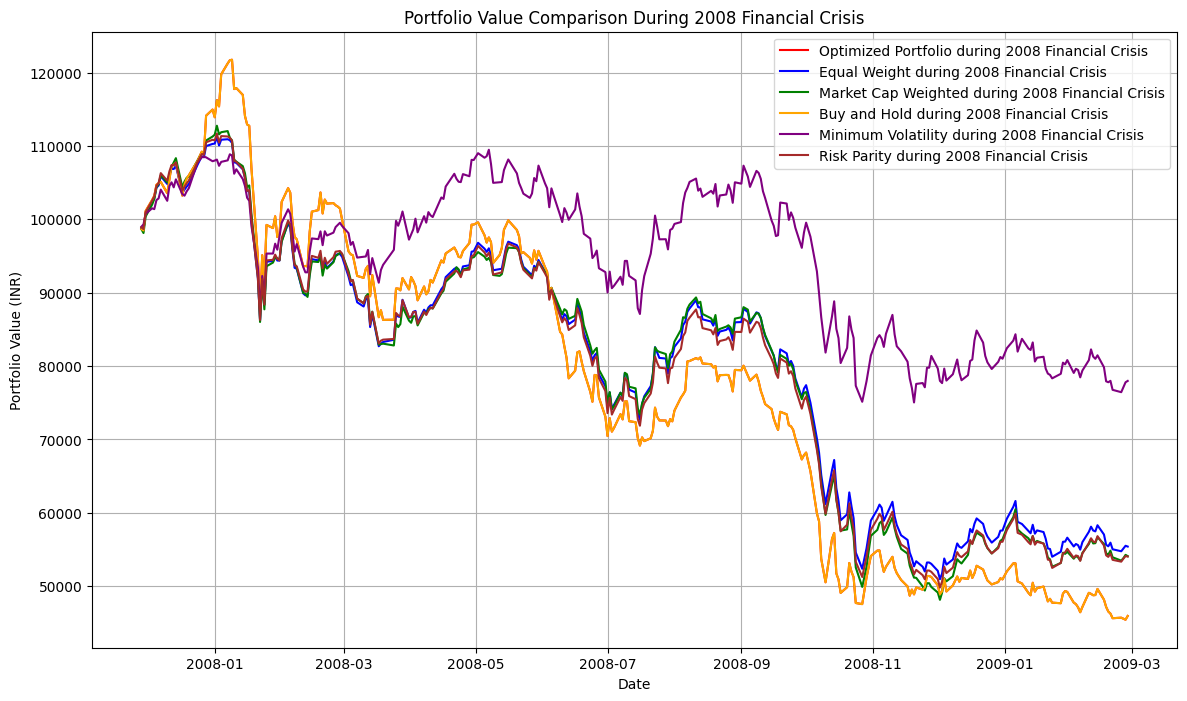

Optimized Portfolio values for 2011 European Debt Crisis:
Date
2010-05-04     99106.595773
2010-05-05    100746.109884
2010-05-06     99850.378334
2010-05-07     99212.294773
2010-05-10    101843.571177
dtype: float64


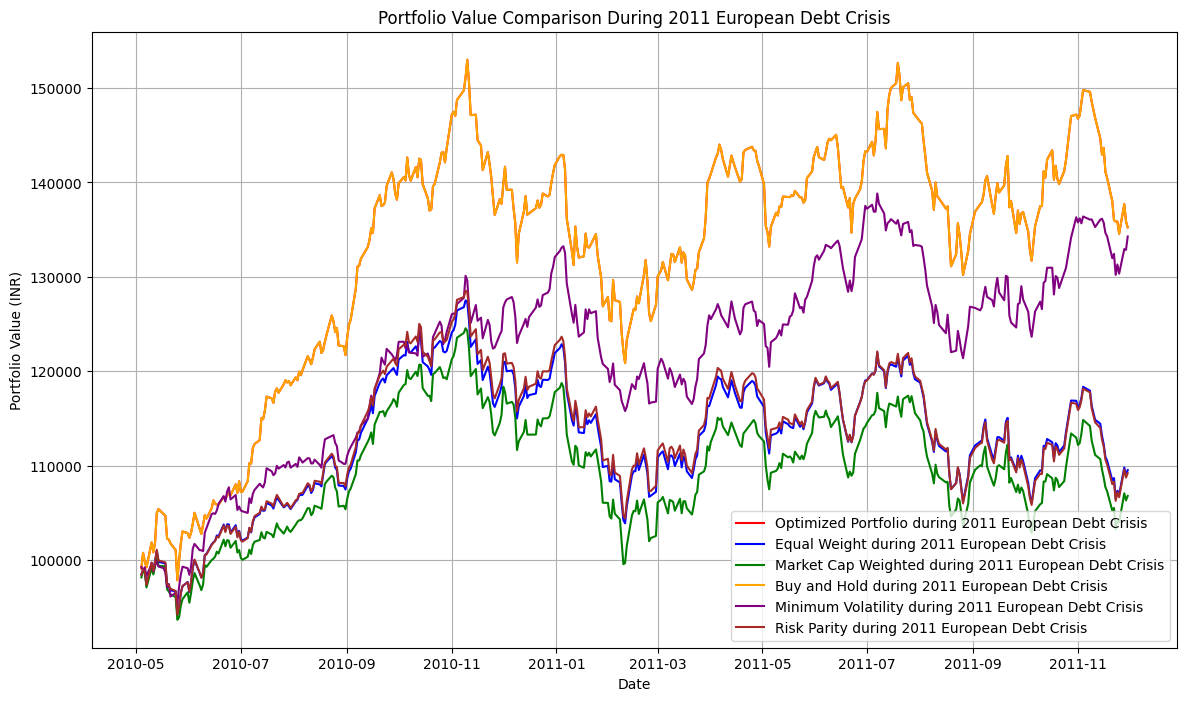

Optimized Portfolio values for 2018 Stock Market Correction:
Date
2018-09-04    99144.718918
2018-09-05    98197.888950
2018-09-06    98489.195414
2018-09-07    99588.970663
2018-09-10    97382.998484
dtype: float64


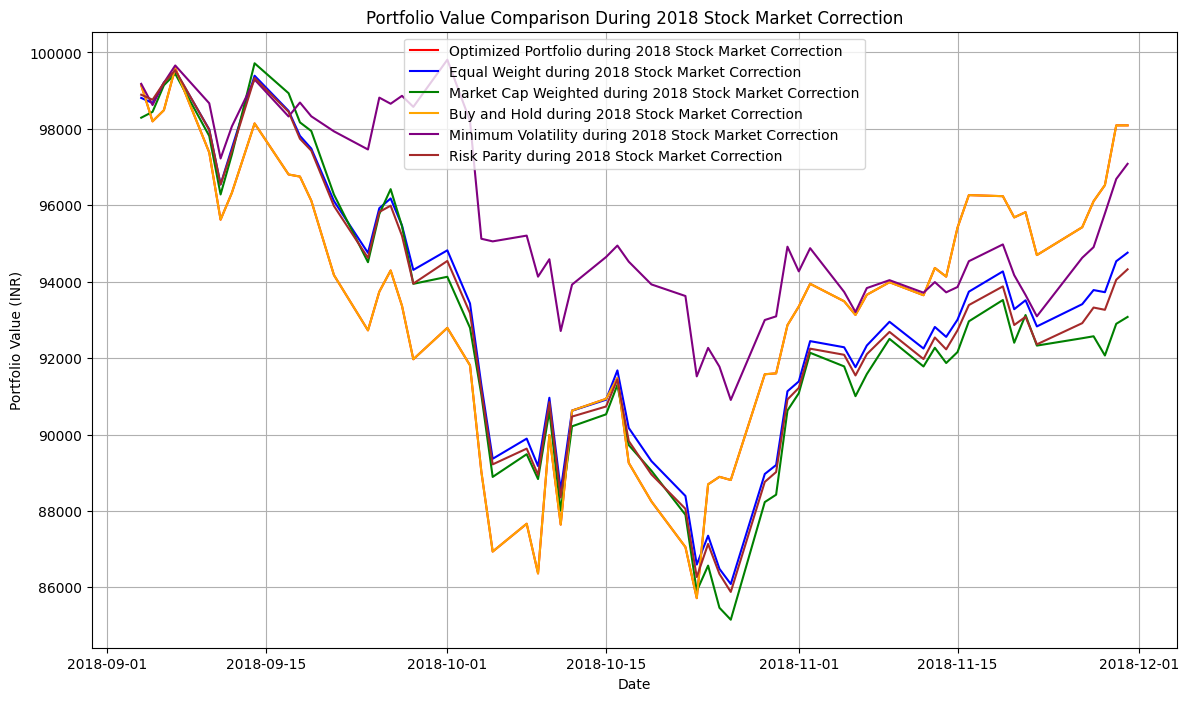

Optimized Portfolio values for COVID-19 Crash:
Date
2020-02-04    103104.832188
2020-02-05    103872.480309
2020-02-06    104666.321225
2020-02-07    105073.570241
2020-02-10    105237.473415
dtype: float64


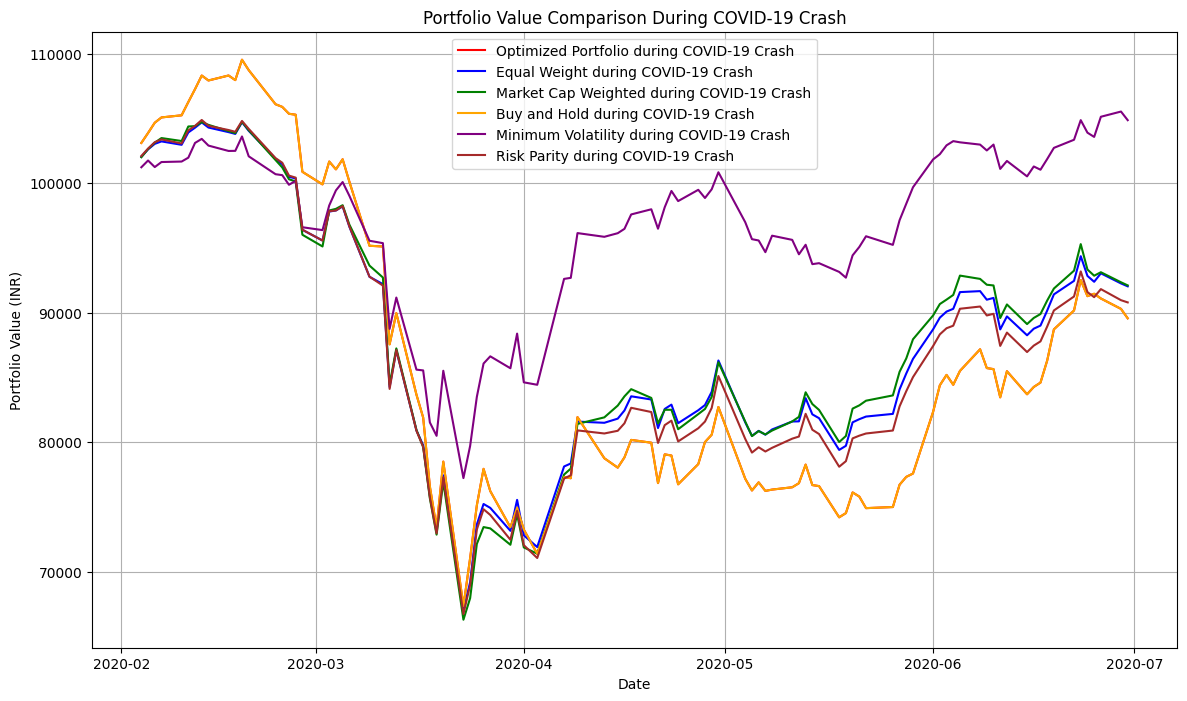

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define multiple stress periods
stress_periods = {
    "2008 Financial Crisis": ("2007-10-01", "2009-03-01"),
    "2011 European Debt Crisis": ("2010-05-01", "2011-12-01"),
    "2018 Stock Market Correction": ("2018-09-01", "2018-12-01"),
    "COVID-19 Crash": ("2020-02-01", "2020-07-01")
}

# Define the selected symbols
selected_symbols = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
    'LT.NS', 'MARUTI.NS', 'BAJFINANCE.NS', 'SBIN.NS', 'ASIANPAINT.NS',
    'TITAN.NS', 'TECHM.NS', 'DIVISLAB.NS', 'ADANIPORTS.NS', 'SUNPHARMA.NS',
    'JSWSTEEL.NS', 'GRASIM.NS', 'CIPLA.NS', 'ULTRACEMCO.NS', 'UPL.NS'
]

# Assume you have the initial portfolio value defined
initial_portfolio_value = 100000  # Replace with actual initial value

# Define the strategies with their weights
equal_weighted_weights = pd.Series(np.ones(len(selected_symbols)) / len(selected_symbols), index=selected_symbols)

market_caps = np.array([100, 200, 150, 300, 250, 400, 350, 500, 450, 600,  # Replace with actual market caps
                        550, 650, 700, 750, 800, 850, 900, 950, 1000, 1050])
market_cap_weighted_weights = pd.Series(market_caps / np.sum(market_caps), index=selected_symbols)

# Assuming you have already calculated the following:
# cleaned_weights is assumed to be your optimized portfolio weights
buy_and_hold_weights = pd.Series(cleaned_weights, index=selected_symbols)  # Copy of optimized weights for Buy and Hold
min_vol_weights = pd.Series(min_vol_weights, index=selected_symbols)  # Replace with actual min volatility weights
risk_parity_weights = pd.Series(risk_parity_weights, index=selected_symbols)  # Replace with actual risk parity weights
optimized_weights = pd.Series(cleaned_weights, index=selected_symbols)  # Optimized portfolio weights

# Debugging: Print cleaned_weights to ensure it's correctly defined
print("Optimized Portfolio Weights (cleaned_weights):")
print(optimized_weights)

# Store all strategies in a dictionary
strategy_weights = {
    'Optimized Portfolio': optimized_weights,
    'Equal Weight': equal_weighted_weights,
    'Market Cap Weighted': market_cap_weighted_weights,
    'Buy and Hold': buy_and_hold_weights,
    'Minimum Volatility': min_vol_weights,
    'Risk Parity': risk_parity_weights
}

# Define colors for each strategy
strategy_colors = {
    'Optimized Portfolio': 'red',
    'Equal Weight': 'blue',
    'Market Cap Weighted': 'green',
    'Buy and Hold': 'orange',
    'Minimum Volatility': 'purple',
    'Risk Parity': 'brown'
}

# Initialize a dictionary to store results for each stress period
stress_test_results = {}

# Loop over each stress period
for period_name, (start_date, end_date) in stress_periods.items():
    print(f"\nAnalyzing {period_name}...")

    # Download historical data for the selected symbols during the stress period
    stress_data = yf.download(selected_symbols, start=start_date, end=end_date)['Adj Close']

    # Calculate returns during the stress period
    stress_returns = stress_data.pct_change().dropna()

    # Initialize a dictionary to store portfolio values for each strategy
    portfolio_values = {}

    for strategy_name, weights in strategy_weights.items():
        print(f"\nCalculating for strategy: {strategy_name}")

        # Ensure weights are a pandas Series
        weights = pd.Series(weights)

        # Align weights with the stress_returns data
        aligned_weights = weights.reindex(stress_returns.columns, fill_value=0)

        # Calculate portfolio returns using the strategy-specific weights
        strategy_returns = (stress_returns * aligned_weights).sum(axis=1)

        # Calculate the portfolio value for the strategy
        strategy_portfolio_value = (1 + strategy_returns).cumprod() * initial_portfolio_value

        # Check for NaN values in the strategy's portfolio values
        if strategy_portfolio_value.isna().any():
            print(f"Warning: {strategy_name} has NaN values in its portfolio value during {period_name}.")

        # Store the portfolio value in the dictionary
        portfolio_values[strategy_name] = strategy_portfolio_value

    # Store the results for this stress period
    stress_test_results[period_name] = portfolio_values

# Visualize the results for each stress period
for period_name, portfolio_values in stress_test_results.items():
    plt.figure(figsize=(14, 8))

    # Plot all strategies with distinct colors
    for strategy_name, values in portfolio_values.items():
        plt.plot(values, label=f"{strategy_name} during {period_name}", color=strategy_colors[strategy_name])

    # Explicitly check if the optimized portfolio is plotted
    if 'Optimized Portfolio' not in portfolio_values:
        print(f"Error: Optimized Portfolio not found in results for {period_name}.")
    else:
        print(f"Optimized Portfolio values for {period_name}:")
        print(portfolio_values['Optimized Portfolio'].head())

    plt.title(f"Portfolio Value Comparison During {period_name}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (INR)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Hypothetical sensitivities (for simplicity, assume all assets have the same sensitivity)
interest_rate_sensitivity = np.array([-0.5, -0.3, -0.4, -0.2, -0.3, -0.2, -0.5, -0.3, -0.4, -0.3,
                                      -0.2, -0.4, -0.3, -0.2, -0.3, -0.2, -0.4, -0.3, -0.2, -0.3])
inflation_sensitivity = np.array([-0.2, -0.1, -0.2, -0.1, -0.2, -0.1, -0.3, -0.2, -0.3, -0.2,
                                  -0.1, -0.2, -0.2, -0.1, -0.2, -0.1, -0.2, -0.2, -0.1, -0.2])

# Adjust expected returns for the shocks
mu_shocked = mu + (interest_rate_shock * interest_rate_sensitivity + inflation_shock * inflation_sensitivity)

# Calculate portfolio returns under the shocked conditions
portfolio_returns_shocked = (mu_shocked * pd.Series(cleaned_weights)).sum(axis=0)

# Simulate the impact on the portfolio value
shocked_portfolio_value = initial_portfolio_value * (1 + portfolio_returns_shocked)

# Output the shocked portfolio value
print(f"Portfolio value under shocked conditions: {shocked_portfolio_value:.2f} INR")


Portfolio value under shocked conditions: 126834.37 INR


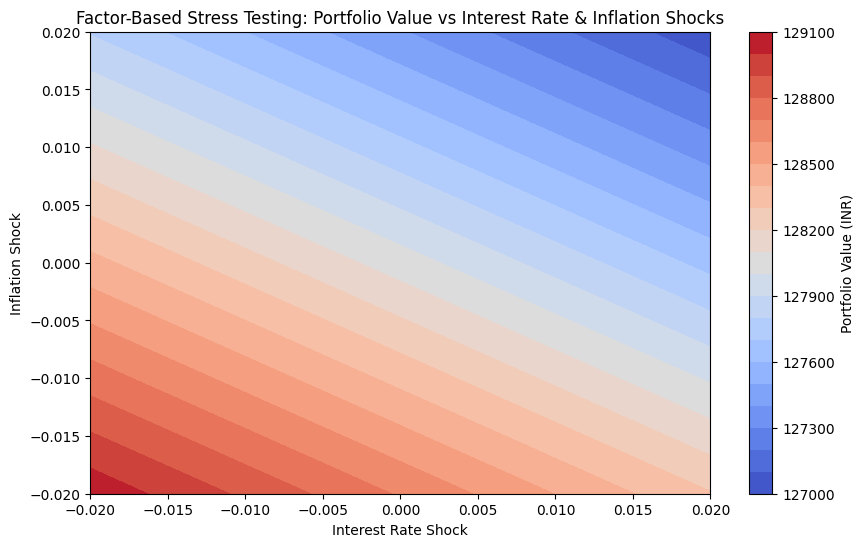

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of shocks for interest rates and inflation
interest_rate_shocks = np.linspace(-0.02, 0.02, 5)  # Interest rate shocks from -2% to 2%
inflation_shocks = np.linspace(-0.02, 0.02, 5)  # Inflation shocks from -2% to 2%

# Store results for different combinations of shocks
factor_test_results = []

# Loop over each combination of interest rate and inflation shocks
for ir_shock in interest_rate_shocks:
    for infl_shock in inflation_shocks:
        # Adjust expected returns for the current shocks
        mu_shocked = mu + (ir_shock * interest_rate_sensitivity + infl_shock * inflation_sensitivity)

        # Calculate portfolio returns under the shocked conditions
        portfolio_returns_shocked = (mu_shocked * pd.Series(cleaned_weights)).sum(axis=0)

        # Calculate the portfolio value
        shocked_portfolio_value = initial_portfolio_value * (1 + portfolio_returns_shocked)
        factor_test_results.append((ir_shock, infl_shock, shocked_portfolio_value))

# Convert results to a structured array for easy plotting
factor_test_results = np.array(factor_test_results, dtype=[('ir_shock', float), ('infl_shock', float), ('portfolio_value', float)])

# Create a 2D grid for the interest rate and inflation shocks
ir_grid, infl_grid = np.meshgrid(interest_rate_shocks, inflation_shocks)

# Reshape the portfolio values to match the grid for plotting
portfolio_values_grid = factor_test_results['portfolio_value'].reshape(ir_grid.shape)

# Plot the portfolio value as a function of interest rate and inflation shocks
plt.figure(figsize=(10, 6))
cp = plt.contourf(ir_grid, infl_grid, portfolio_values_grid, cmap='coolwarm', levels=20)
plt.colorbar(cp, label='Portfolio Value (INR)')
plt.title('Factor-Based Stress Testing: Portfolio Value vs Interest Rate & Inflation Shocks')
plt.xlabel('Interest Rate Shock')
plt.ylabel('Inflation Shock')
plt.show()


In [ ]:
# Define sensitivity analysis parameters
sensitivity_range = np.linspace(-0.10, 0.10, 5)  # Test a 10% decrease to a 10% increase in returns

# Store results for different sensitivity scenarios
sensitivity_results = []

for shock in sensitivity_range:
    # Adjust expected returns by the shock amount
    mu_sensitivity = mu + shock

    # Calculate portfolio returns under the sensitivity scenario
    portfolio_returns_sensitivity = (mu_sensitivity * pd.Series(cleaned_weights)).sum(axis=0)

    # Calculate the portfolio value
    portfolio_value_sensitivity = initial_portfolio_value * (1 + portfolio_returns_sensitivity)
    sensitivity_results.append(portfolio_value_sensitivity)

# Output the results for different sensitivity scenarios
for shock, value in zip(sensitivity_range, sensitivity_results):
    print(f"Portfolio value with return shock of {shock*100:.1f}%: {value:.2f} INR")


Portfolio value with return shock of -10.0%: 118048.48 INR
Portfolio value with return shock of -5.0%: 123048.48 INR
Portfolio value with return shock of 0.0%: 128048.48 INR
Portfolio value with return shock of 5.0%: 133048.48 INR
Portfolio value with return shock of 10.0%: 138048.48 INR


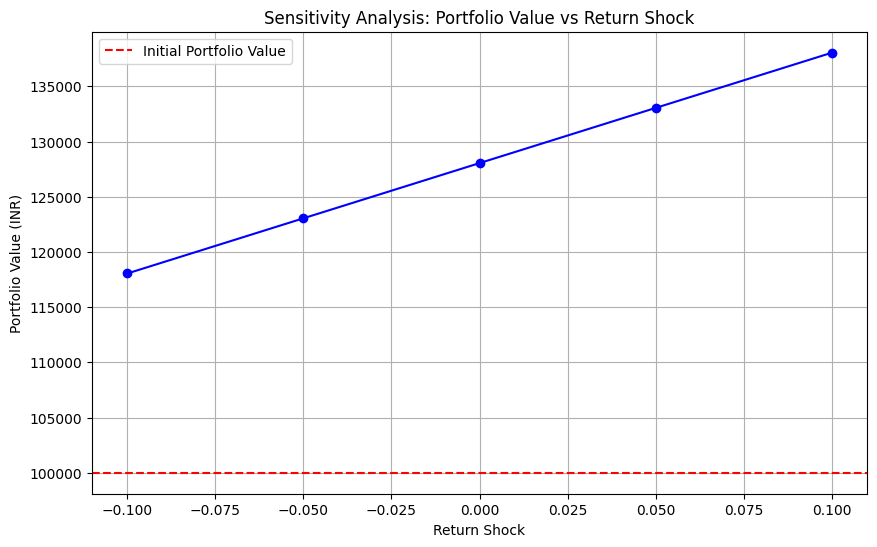

In [ ]:
# Define sensitivity analysis parameters
sensitivity_range = np.linspace(-0.10, 0.10, 5)  # Test a 10% decrease to a 10% increase in returns

# Store results for different sensitivity scenarios
sensitivity_values = []

for shock in sensitivity_range:
    # Adjust expected returns by the shock amount
    mu_sensitivity = mu + shock

    # Calculate portfolio returns under the sensitivity scenario
    portfolio_returns_sensitivity = (mu_sensitivity * pd.Series(cleaned_weights)).sum(axis=0)

    # Calculate the portfolio value
    portfolio_value_sensitivity = initial_portfolio_value * (1 + portfolio_returns_sensitivity)
    sensitivity_values.append(portfolio_value_sensitivity)

# Plot the results of the sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_range, sensitivity_values, marker='o', linestyle='-', color='b')
plt.axhline(y=initial_portfolio_value, color='r', linestyle='--', label='Initial Portfolio Value')
plt.title('Sensitivity Analysis: Portfolio Value vs Return Shock')
plt.xlabel('Return Shock')
plt.ylabel('Portfolio Value (INR)')
plt.grid(True)
plt.legend()
plt.show()
